In [1]:
import numpy as np
import pandas as pd
import torch

import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from models.base_regressor import BaseRegressor
import training as methods

In [2]:
####################
# LOADING THE DATA #
####################
SUBJECTS = ['AT', 'EL', 'HH', 'MS', 'RB', 'RL', 'TT']
SCENES = ['FlatWalkStraight', 'FlatWalkCircular', 'FlatWalkStatic']
TRIALS = ('all')

gait_cycles = methods.read_gait_cycles(SUBJECTS, SCENES, TRIALS)

Reading BW jogging_1.csv
Reading BW jogging_2.csv
Reading BW jogging_3.csv
Reading BW jogging_4_badStep.csv
Reading BW jogging_5.csv
Reading BW jogging_6_badForcePlate.csv
Reading BW jogging_7.csv
Reading BW jogging_8.csv
Reading Bw stop FW walking_1.csv
Reading Bw stop FW walking_2.csv
Reading Bw stop FW walking_3.csv
Reading Bw stop FW walking_4.csv
Reading Bw stop FW walking_5.csv
Reading Bw stop FW walking_6.csv
Reading Bw stop FW walking_7.csv
Reading BW walking_1_badForcePlate.csv
Reading BW walking_2.csv
Reading BW walking_4.csv
Reading BW walking_5.csv
Reading BW walking_6_badForcePlate.csv
Reading BW walking_7_badForcePlate.csv
Reading BW walking_8.csv
Reading BW-L walking_1.csv
Reading BW-L walking_2_badForcePlate.csv
Reading BW-L walking_3.csv
Reading BW-L walking_4_badForcePlate.csv
Reading BW-L walking_5_badForcePlate.csv
Reading BW-R walking_1_badForcePlate.csv
Reading BW-R walking_2.csv
Reading BW-R walking_3.csv
Reading BW-R walking_4.csv
Reading BW-R walking_5.csv
Read

In [3]:
##############################################
# LEFT VS. RIGHT FOOT -> MAIN VS. OTHER FOOT #
##############################################
df_l, df_r = methods.homogenize(gait_cycles)
df_homogenous = pd.concat([df_l, df_r])

In [4]:
#############
# FILTERING #
#############
df_filtered = methods.filter(df_homogenous)

df_filtered.groupby(['trial'])['trial'].count()

trial
BW jogging_1.csv                           211
BW jogging_10.csv                           30
BW jogging_1_badForcePlate.csv              22
BW jogging_2.csv                           235
BW jogging_2_badForcePlate.csv              24
                                          ... 
Sidestepping normal_6.csv                  820
Sidestepping normal_6_badForcePlate.csv    150
Sidestepping normal_7.csv                  358
Sidestepping normal_8.csv                  373
Sidestepping normal_9.csv                  202
Name: trial, Length: 249, dtype: int64

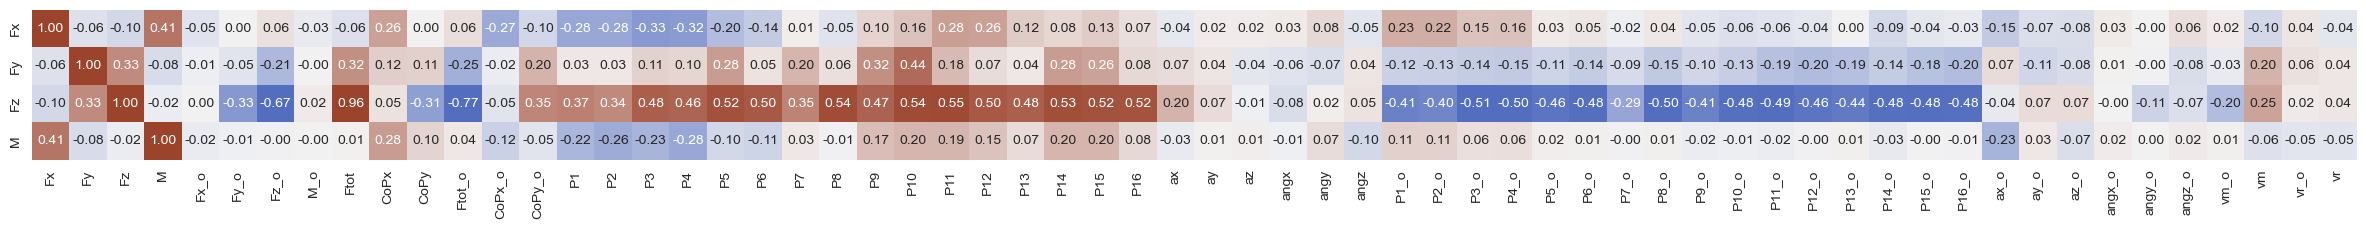

In [5]:
import seaborn as sns

plt.figure(figsize=(30, 10))
corr = df_filtered.iloc[:, :62].corr()
corr_dep = corr.iloc[0:4]
cmap = sns.diverging_palette(260, 20, s=75, l=40, n=5, center="light", as_cmap=True)
sns.heatmap(corr_dep, cmap=cmap, center=0, annot=True, fmt='.2f', square=True, robust=True, cbar=False)

plt.show()

In [6]:
####################
# TRAIN-TEST SPLIT #
####################
df_full_train, df_test = train_test_split(df_filtered, test_size=0.2, random_state=42, stratify=df_filtered['trial'])

In [7]:
############################
# FEATURE/LABEL EXTRACTION #
############################
# Features
X_full_train = methods.extract_features(df_full_train)
X_test = methods.extract_features(df_test)

print('X_full_train:', np.shape(X_full_train))

# Labels
Fx_full_train = df_full_train['Fx']
Fy_full_train = df_full_train['Fy']
Fz_full_train = df_full_train['Fz']
M_full_train  = df_full_train['M']
Fx_test = df_test['Fx']
Fy_test = df_test['Fy']
Fz_test = df_test['Fz']
M_test  = df_test['M']

print('Fx_full_train:', np.shape(Fx_full_train))

# Partitions
partition_full_train = df_full_train['trial']
partition_test = df_test['trial']

print('partition_full_train:', np.shape(partition_full_train))

X_full_train: (51884, 338)
Fx_full_train: (51884,)
partition_full_train: (51884,)


In [8]:
DIR = '../results/' + time.strftime("%Y%m%d-%H%M%S/", time.localtime())

###############
# PERFORM PCA #
###############
X_pc_full_train, X_pc_test = methods.perform_pca(X_full_train, X_test, DIR)
nr_of_features = np.shape(X_pc_full_train)[1]

Number of features before PCA 338
Number of features after PCA 150


In [9]:
######################
# CONVERT TO TENSORS #
######################
# Features
X_full_train_tensor = torch.tensor(X_pc_full_train, dtype=torch.float32)
X_test_tensor       = torch.tensor(X_pc_test, dtype=torch.float32)

# Labels
Fx_full_train_tensor = torch.tensor(Fx_full_train.to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fy_full_train_tensor = torch.tensor(Fy_full_train.to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fz_full_train_tensor = torch.tensor(Fz_full_train.to_numpy().reshape((-1, 1)), dtype=torch.float32)
M_full_train_tensor  = torch.tensor(M_full_train.to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fx_test_tensor = torch.tensor(Fx_test.to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fy_test_tensor = torch.tensor(Fy_test.to_numpy().reshape((-1, 1)), dtype=torch.float32)
Fz_test_tensor = torch.tensor(Fz_test.to_numpy().reshape((-1, 1)), dtype=torch.float32)
M_test_tensor  = torch.tensor(M_test.to_numpy().reshape((-1, 1)), dtype=torch.float32)

Performance on the test set:
NRMSE = 0.0835
r = 0.8867081785206263


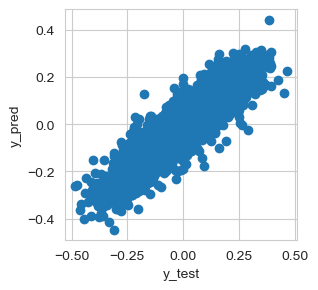

In [10]:
################
# Fx REGRESSOR #
################
Fx_regressor = BaseRegressor(nr_of_features, [42])
Fx_regressor.train_(X_full_train_tensor, Fx_full_train_tensor)

# Evaluate the model
Fx_regressor.eval()
Fx_pred_tensor = Fx_regressor(X_test_tensor)
methods.print_metrics(Fx_test_tensor, Fx_pred_tensor)

Fx_regressor.save(DIR, 'Fx_base')

Performance on the test set:
NRMSE = 0.0782
r = 0.8915082530477455


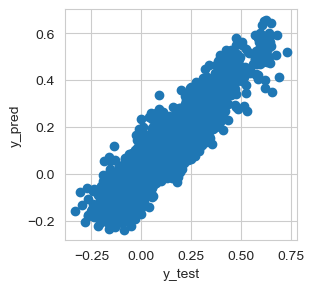

In [11]:
################
# Fy REGRESSOR #
################
Fy_regressor = BaseRegressor(nr_of_features, [42])
Fy_regressor.train_(X_full_train_tensor, Fy_full_train_tensor)

# Evaluate the model
Fy_regressor.eval()
Fy_pred_tensor = Fy_regressor(X_test_tensor)
methods.print_metrics(Fy_test_tensor, Fy_pred_tensor)

Fy_regressor.save(DIR, 'Fy_base')

Performance on the test set:
NRMSE = 0.0549
r = 0.9764099690290133


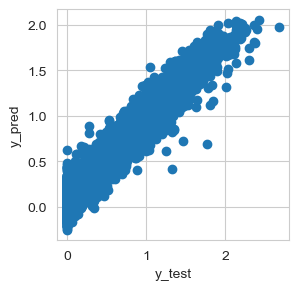

In [12]:
################
# Fz REGRESSOR #
################
Fz_regressor = BaseRegressor(nr_of_features, [42])
Fz_regressor.train_(X_full_train_tensor, Fz_full_train_tensor)

# Evaluate the model
Fz_regressor.eval()
Fz_pred_tensor = Fz_regressor(X_test_tensor)
methods.print_metrics(Fz_test_tensor, Fz_pred_tensor)

Fz_regressor.save(DIR, 'Fz_base')

Performance on the test set:
NRMSE = 0.1349
r = 0.6720619757946749


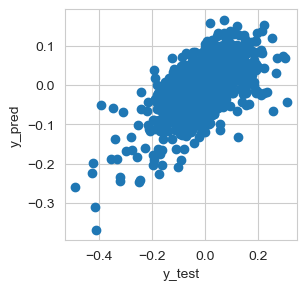

In [13]:
###############
# M REGRESSOR #
###############
M_regressor = BaseRegressor(nr_of_features, [50])
M_regressor.train_(X_full_train_tensor, M_full_train_tensor)

# Evaluate the model
M_regressor.eval()
M_pred_tensor = M_regressor(X_test_tensor)
methods.print_metrics(M_test_tensor, M_pred_tensor)

M_regressor.save(DIR, 'M_base')

In [14]:
import optuna

##################
# MODEL TRAINING #
##################
comp = 'Fy'
K = 5

# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    ## a. Number of layers
    n_layers = trial.suggest_int('hidden_layers', 1, 2)
    
    ## b. Number of neurons per layer
    hidden_sizes = []
    for i in range(n_layers):
        size = trial.suggest_int(f'hidden_size_{i}', 2, 64)
        hidden_sizes.append(size)
    
    # 3. Cross-validate the suggested model
    l, r = methods.cross_validate(hidden_sizes, X_full_train, Fy_full_train, K, partition_full_train, DIR)
    return np.mean(l)

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-05-14 10:07:07,348] A new study created in memory with name: no-name-a2c8c4d8-8613-4931-9af4-06546acf10fd


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:08:28,576] Trial 0 finished with value: 0.04130026325583458 and parameters: {'hidden_layers': 2, 'hidden_size_0': 64, 'hidden_size_1': 18}. Best is trial 0 with value: 0.04130026325583458.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:09:48,122] Trial 1 finished with value: 0.0431279756128788 and parameters: {'hidden_layers': 2, 'hidden_size_0': 42, 'hidden_size_1': 63}. Best is trial 0 with value: 0.04130026325583458.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:10:29,039] Trial 2 finished with value: 0.044636355340480806 and parameters: {'hidden_layers': 1, 'hidden_size_0': 41}. Best is trial 0 with value: 0.04130026325583458.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:11:23,328] Trial 3 finished with value: 0.042705414444208147 and parameters: {'hidden_layers': 1, 'hidden_size_0': 53}. Best is trial 0 with value: 0.04130026325583458.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:12:26,111] Trial 4 finished with value: 0.039818762242794035 and parameters: {'hidden_layers': 2, 'hidden_size_0': 57, 'hidden_size_1': 21}. Best is trial 4 with value: 0.039818762242794035.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:13:21,789] Trial 5 finished with value: 0.048905526846647264 and parameters: {'hidden_layers': 2, 'hidden_size_0': 17, 'hidden_size_1': 18}. Best is trial 4 with value: 0.039818762242794035.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:14:23,741] Trial 6 finished with value: 0.04394446387887001 and parameters: {'hidden_layers': 1, 'hidden_size_0': 44}. Best is trial 4 with value: 0.039818762242794035.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:15:22,063] Trial 7 finished with value: 0.0403658002614975 and parameters: {'hidden_layers': 2, 'hidden_size_0': 55, 'hidden_size_1': 14}. Best is trial 4 with value: 0.039818762242794035.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:16:04,628] Trial 8 finished with value: 0.04982770010828972 and parameters: {'hidden_layers': 1, 'hidden_size_0': 18}. Best is trial 4 with value: 0.039818762242794035.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:17:00,290] Trial 9 finished with value: 0.044765043258666995 and parameters: {'hidden_layers': 1, 'hidden_size_0': 44}. Best is trial 4 with value: 0.039818762242794035.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:17:51,361] Trial 10 finished with value: 0.06761133000254631 and parameters: {'hidden_layers': 2, 'hidden_size_0': 2, 'hidden_size_1': 42}. Best is trial 4 with value: 0.039818762242794035.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:18:58,227] Trial 11 finished with value: 0.0572939544916153 and parameters: {'hidden_layers': 2, 'hidden_size_0': 64, 'hidden_size_1': 2}. Best is trial 4 with value: 0.039818762242794035.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:20:15,803] Trial 12 finished with value: 0.04422357976436615 and parameters: {'hidden_layers': 2, 'hidden_size_0': 55, 'hidden_size_1': 21}. Best is trial 4 with value: 0.039818762242794035.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:20:57,673] Trial 13 finished with value: 0.056513530761003496 and parameters: {'hidden_layers': 2, 'hidden_size_0': 27, 'hidden_size_1': 4}. Best is trial 4 with value: 0.039818762242794035.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:22:26,715] Trial 14 finished with value: 0.0402137964963913 and parameters: {'hidden_layers': 2, 'hidden_size_0': 58, 'hidden_size_1': 35}. Best is trial 4 with value: 0.039818762242794035.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:23:28,204] Trial 15 finished with value: 0.0433466911315918 and parameters: {'hidden_layers': 2, 'hidden_size_0': 32, 'hidden_size_1': 37}. Best is trial 4 with value: 0.039818762242794035.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:24:58,691] Trial 16 finished with value: 0.0413757786154747 and parameters: {'hidden_layers': 2, 'hidden_size_0': 52, 'hidden_size_1': 46}. Best is trial 4 with value: 0.039818762242794035.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:26:33,672] Trial 17 finished with value: 0.03928611502051353 and parameters: {'hidden_layers': 2, 'hidden_size_0': 60, 'hidden_size_1': 30}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:27:45,956] Trial 18 finished with value: 0.040346410125494 and parameters: {'hidden_layers': 2, 'hidden_size_0': 48, 'hidden_size_1': 26}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:28:47,824] Trial 19 finished with value: 0.044285185635089874 and parameters: {'hidden_layers': 2, 'hidden_size_0': 34, 'hidden_size_1': 29}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:29:51,173] Trial 20 finished with value: 0.04219571873545647 and parameters: {'hidden_layers': 1, 'hidden_size_0': 60}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:31:25,282] Trial 21 finished with value: 0.040787873417139055 and parameters: {'hidden_layers': 2, 'hidden_size_0': 59, 'hidden_size_1': 35}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:32:58,020] Trial 22 finished with value: 0.03946395218372345 and parameters: {'hidden_layers': 2, 'hidden_size_0': 59, 'hidden_size_1': 47}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:34:33,398] Trial 23 finished with value: 0.04124518558382988 and parameters: {'hidden_layers': 2, 'hidden_size_0': 49, 'hidden_size_1': 53}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:35:59,484] Trial 24 finished with value: 0.039294590801000596 and parameters: {'hidden_layers': 2, 'hidden_size_0': 63, 'hidden_size_1': 56}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:37:21,886] Trial 25 finished with value: 0.039321182668209075 and parameters: {'hidden_layers': 2, 'hidden_size_0': 61, 'hidden_size_1': 56}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:38:59,765] Trial 26 finished with value: 0.03976444602012634 and parameters: {'hidden_layers': 2, 'hidden_size_0': 64, 'hidden_size_1': 62}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:40:31,665] Trial 27 finished with value: 0.04149928689002991 and parameters: {'hidden_layers': 2, 'hidden_size_0': 49, 'hidden_size_1': 56}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:41:46,180] Trial 28 finished with value: 0.04318284839391708 and parameters: {'hidden_layers': 2, 'hidden_size_0': 37, 'hidden_size_1': 54}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:43:05,716] Trial 29 finished with value: 0.03958749994635582 and parameters: {'hidden_layers': 2, 'hidden_size_0': 63, 'hidden_size_1': 42}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:44:11,020] Trial 30 finished with value: 0.06684425100684166 and parameters: {'hidden_layers': 2, 'hidden_size_0': 2, 'hidden_size_1': 58}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:45:58,378] Trial 31 finished with value: 0.03979830667376518 and parameters: {'hidden_layers': 2, 'hidden_size_0': 61, 'hidden_size_1': 50}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:48:28,490] Trial 32 finished with value: 0.04096648842096329 and parameters: {'hidden_layers': 2, 'hidden_size_0': 52, 'hidden_size_1': 48}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:51:31,025] Trial 33 finished with value: 0.040537475049495696 and parameters: {'hidden_layers': 2, 'hidden_size_0': 59, 'hidden_size_1': 59}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:54:00,851] Trial 34 finished with value: 0.03938736990094185 and parameters: {'hidden_layers': 2, 'hidden_size_0': 64, 'hidden_size_1': 42}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:56:31,317] Trial 35 finished with value: 0.039445514976978305 and parameters: {'hidden_layers': 2, 'hidden_size_0': 64, 'hidden_size_1': 41}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:58:28,742] Trial 36 finished with value: 0.040638315677642825 and parameters: {'hidden_layers': 2, 'hidden_size_0': 55, 'hidden_size_1': 29}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 10:59:47,233] Trial 37 finished with value: 0.043401457369327545 and parameters: {'hidden_layers': 1, 'hidden_size_0': 47}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 11:03:13,344] Trial 38 finished with value: 0.040153924375772476 and parameters: {'hidden_layers': 2, 'hidden_size_0': 53, 'hidden_size_1': 52}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 11:06:21,440] Trial 39 finished with value: 0.040320129692554475 and parameters: {'hidden_layers': 2, 'hidden_size_0': 56, 'hidden_size_1': 62}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 11:07:28,416] Trial 40 finished with value: 0.04426563009619713 and parameters: {'hidden_layers': 1, 'hidden_size_0': 41}. Best is trial 17 with value: 0.03928611502051353.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 11:09:31,260] Trial 41 finished with value: 0.038954831659793854 and parameters: {'hidden_layers': 2, 'hidden_size_0': 64, 'hidden_size_1': 40}. Best is trial 41 with value: 0.038954831659793854.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 11:11:32,514] Trial 42 finished with value: 0.03914457410573959 and parameters: {'hidden_layers': 2, 'hidden_size_0': 61, 'hidden_size_1': 38}. Best is trial 41 with value: 0.038954831659793854.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 11:13:28,643] Trial 43 finished with value: 0.03912748694419861 and parameters: {'hidden_layers': 2, 'hidden_size_0': 61, 'hidden_size_1': 30}. Best is trial 41 with value: 0.038954831659793854.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 11:14:30,900] Trial 44 finished with value: 0.052212965488433835 and parameters: {'hidden_layers': 2, 'hidden_size_0': 11, 'hidden_size_1': 31}. Best is trial 41 with value: 0.038954831659793854.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 11:16:31,872] Trial 45 finished with value: 0.04012660458683968 and parameters: {'hidden_layers': 2, 'hidden_size_0': 56, 'hidden_size_1': 27}. Best is trial 41 with value: 0.038954831659793854.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 11:18:32,538] Trial 46 finished with value: 0.04099857807159424 and parameters: {'hidden_layers': 2, 'hidden_size_0': 51, 'hidden_size_1': 22}. Best is trial 41 with value: 0.038954831659793854.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 11:20:43,164] Trial 47 finished with value: 0.0397838369011879 and parameters: {'hidden_layers': 2, 'hidden_size_0': 61, 'hidden_size_1': 39}. Best is trial 41 with value: 0.038954831659793854.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 11:22:27,455] Trial 48 finished with value: 0.03926267176866531 and parameters: {'hidden_layers': 2, 'hidden_size_0': 56, 'hidden_size_1': 11}. Best is trial 41 with value: 0.038954831659793854.


Fold #1
Number of features before PCA 338
Number of features after PCA 150
Fold #2
Number of features before PCA 338
Number of features after PCA 150
Fold #3
Number of features before PCA 338
Number of features after PCA 150
Fold #4
Number of features before PCA 338
Number of features after PCA 150
Fold #5
Number of features before PCA 338
Number of features after PCA 150


[I 2024-05-14 11:24:01,663] Trial 49 finished with value: 0.04081269949674606 and parameters: {'hidden_layers': 2, 'hidden_size_0': 57, 'hidden_size_1': 12}. Best is trial 41 with value: 0.038954831659793854.
